In [229]:
import os

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [231]:
store_sales = pd.read_csv("ankurbucketsalesdata.csv")
store_sales.head(10)

,date,sales
0,4/1/18,96
1,5/1/18,864
2,6/1/18,1056
3,7/1/18,192
4,8/1/18,1152
5,9/1/18,0
6,10/1/18,576
7,11/1/18,288
8,12/1/18,0
9,1/1/19,0


check for null values in the dataset

In [232]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2112 entries, 0 to 2111
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2112 non-null   object
 1   sales   2112 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB


converting date from object datatype to dateTime datatype

In [233]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [234]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2112 entries, 0 to 2111
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2112 non-null   datetime64[ns]
 1   sales   2112 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 33.1 KB


converting date to month period and then sum the number of items in each month

In [235]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

convert the resulting date to timestamp datatype

In [236]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [237]:
monthly_sales.head(10)

,date,sales
0,2018-04-01,47736
1,2018-05-01,72725
2,2018-06-01,82623
3,2018-07-01,62844
4,2018-08-01,76322
5,2018-09-01,76407
6,2018-10-01,37430
7,2018-11-01,37110
8,2018-12-01,51755
9,2019-01-01,73100


Visualization

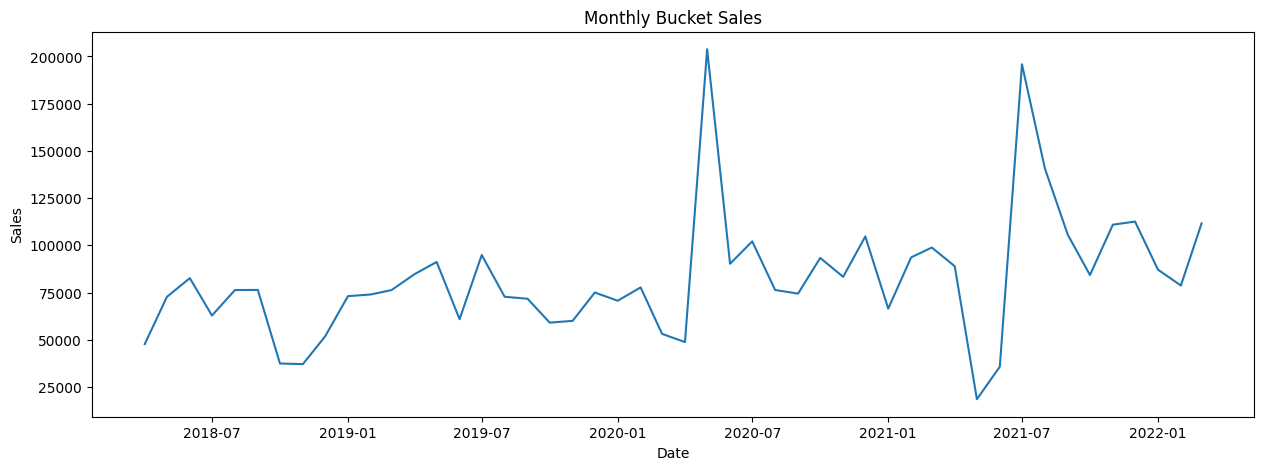

In [238]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly Bucket Sales")
plt.show()

call the difference on the sales columns to make the sales data stationary

In [239]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2018-05-01,72725,24989.0
2,2018-06-01,82623,9898.0
3,2018-07-01,62844,-19779.0
4,2018-08-01,76322,13478.0
5,2018-09-01,76407,85.0
6,2018-10-01,37430,-38977.0
7,2018-11-01,37110,-320.0
8,2018-12-01,51755,14645.0
9,2019-01-01,73100,21345.0
10,2019-02-01,73992,892.0


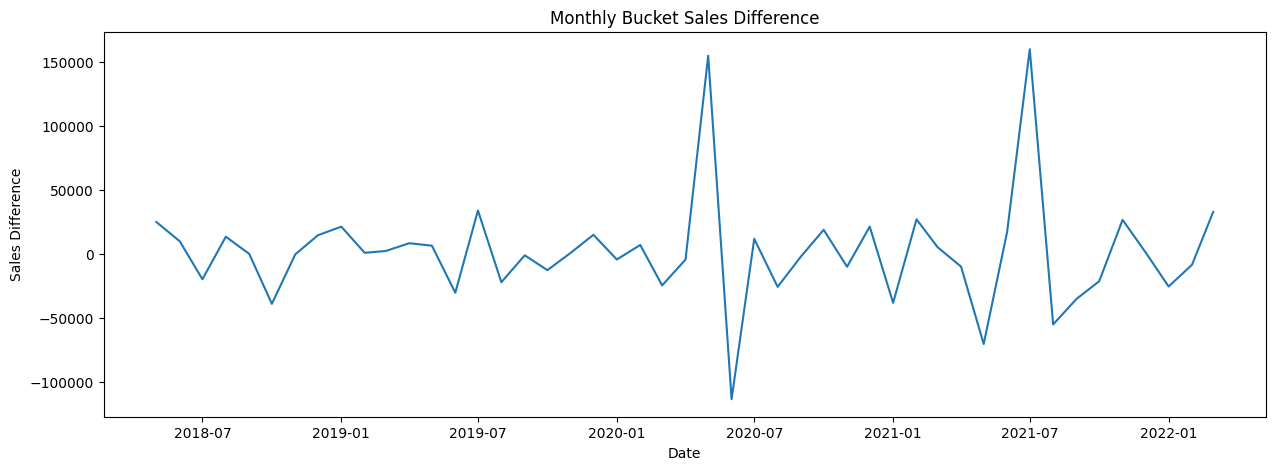

In [240]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel("Date")
plt.ylabel("Sales Difference")
plt.title("Monthly Bucket Sales Difference")
plt.show()

Dropping off sales and date

In [241]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

preparing the supervised data

In [242]:
for i in range(1, 13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,6472.0,8404.0,2338.0,892.0,21345.0,14645.0,-320.0,-38977.0,85.0,13478.0,-19779.0,9898.0,24989.0
1,-30310.0,6472.0,8404.0,2338.0,892.0,21345.0,14645.0,-320.0,-38977.0,85.0,13478.0,-19779.0,9898.0
2,33980.0,-30310.0,6472.0,8404.0,2338.0,892.0,21345.0,14645.0,-320.0,-38977.0,85.0,13478.0,-19779.0
3,-22100.0,33980.0,-30310.0,6472.0,8404.0,2338.0,892.0,21345.0,14645.0,-320.0,-38977.0,85.0,13478.0
4,-1044.0,-22100.0,33980.0,-30310.0,6472.0,8404.0,2338.0,892.0,21345.0,14645.0,-320.0,-38977.0,85.0
5,-12652.0,-1044.0,-22100.0,33980.0,-30310.0,6472.0,8404.0,2338.0,892.0,21345.0,14645.0,-320.0,-38977.0
6,941.0,-12652.0,-1044.0,-22100.0,33980.0,-30310.0,6472.0,8404.0,2338.0,892.0,21345.0,14645.0,-320.0
7,15003.0,941.0,-12652.0,-1044.0,-22100.0,33980.0,-30310.0,6472.0,8404.0,2338.0,892.0,21345.0,14645.0
8,-4346.0,15003.0,941.0,-12652.0,-1044.0,-22100.0,33980.0,-30310.0,6472.0,8404.0,2338.0,892.0,21345.0
9,7049.0,-4346.0,15003.0,941.0,-12652.0,-1044.0,-22100.0,33980.0,-30310.0,6472.0,8404.0,2338.0,892.0


Split the data into Train and Test

In [243]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (23, 13)
Test Data Shape:  (12, 13)


In [244]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)


In [245]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (23, 12)
y_train Shape:  (23,)
X_test Shape:  (12, 12)
y_test Shape:  (12,)


Make prediction data frame to merge the predicted sales prices of all trained algs

In [246]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [247]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[98840, 88952, 18529, 35736, 195836, 140723, 105605, 84287, 110945, 112585, 87130, 78732, 111613]


To create the linear regression model, and predicted output

In [248]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [249]:
lr_pre = lr_pre.reshape(-1,1)
# This is a set matrix - contains the input features of the text data and also the predicted output
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [250]:
result_list = []
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index = True)

In [251]:
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])

print("Linear Regression MSE: ", lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)

Linear Regression MSE:  79627.00847762897
Linear Regression MAE:  56268.64598629286
Linear Regression R2:  -0.9521641442357356


Visualization of the prediction against actual sales

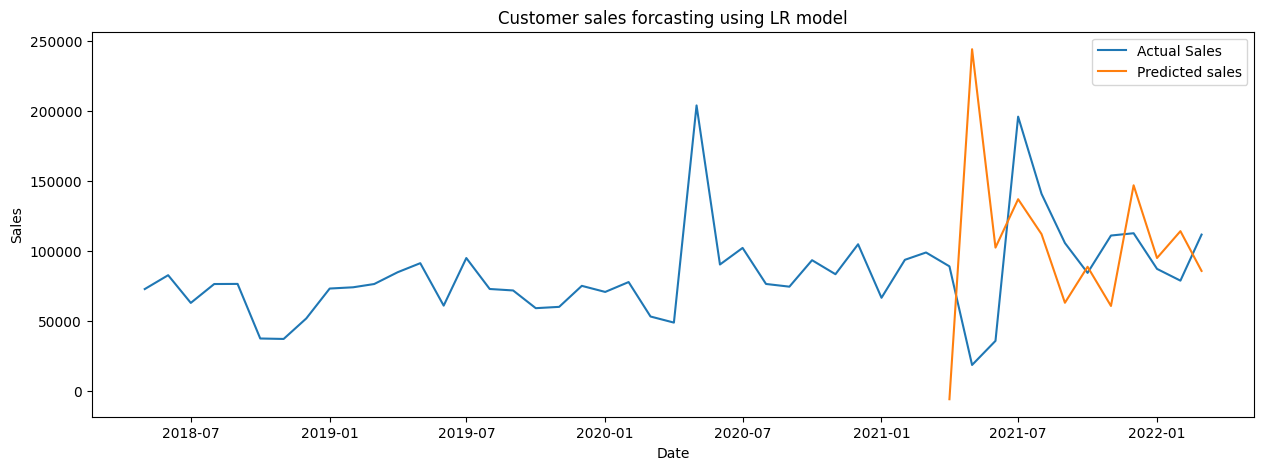

In [254]:
plt.figure(figsize=(15,5))
# Actual sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer sales forcasting using LR model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted sales'])
plt.show()